In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [2]:
# Parameters
img_height, img_width = 224, 224
batch_size = 32
train_data_dir = 'lung/'

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of data used for validation
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 2160 images belonging to 3 classes.
Found 540 images belonging to 3 classes.


In [3]:
# Load the ResNet50 model pre-trained on ImageNet, exclude the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])




94765736/94765736 [==============================] - 49s 1us/step


In [4]:
# Train the model
epochs = 30
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)


Epoch 1/30


67/67 [==============================] - 531s 8s/step - loss: 1.1118 - accuracy: 0.4864 - val_loss: 1.0057 - val_accuracy: 0.4121
Epoch 2/30
67/67 [==============================] - 614s 9s/step - loss: 0.9737 - accuracy: 0.5320 - val_loss: 0.9738 - val_accuracy: 0.5566
Epoch 3/30
67/67 [==============================] - 558s 8s/step - loss: 0.9948 - accuracy: 0.5113 - val_loss: 0.9968 - val_accuracy: 0.3301
Epoch 4/30
67/67 [==============================] - 517s 8s/step - loss: 1.0162 - accuracy: 0.4962 - val_loss: 0.9726 - val_accuracy: 0.5547
Epoch 5/30
67/67 [==============================] - 571s 9s/step - loss: 0.9632 - accuracy: 0.5338 - val_loss: 0.9470 - val_accuracy: 0.5547
Epoch 6/30
67/67 [==============================] - 559s 8s/step - loss: 0.9481 - accuracy: 0.5503 - val_loss: 0.9525 - val_accuracy: 0.5469
Epoch 7/30
67/67 [==============================] - 481s 7s/step - loss: 0.9666 - accuracy: 0.5442 - val_loss: 0.9453 - val_accuracy: 0.5488
Epoch 8/30


In [5]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


17/17 [==============================] - 32s 2s/step - loss: 0.9473 - accuracy: 0.5556
Validation Accuracy: 55.56%


In [6]:
# Save the model
model.save('resnet50_model.h5')


C:\Users\AK Treader\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 34s 2s/step
              precision    recall  f1-score   support

        Test       0.00      0.00      0.00       180
       Train       0.56      1.00      0.71       300
         Val       0.00      0.00      0.00        60

    accuracy                           0.56       540
   macro avg       0.19      0.33      0.24       540
weighted avg       0.31      0.56      0.40       540



C:\Users\AK Treader\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AK Treader\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\AK Treader\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

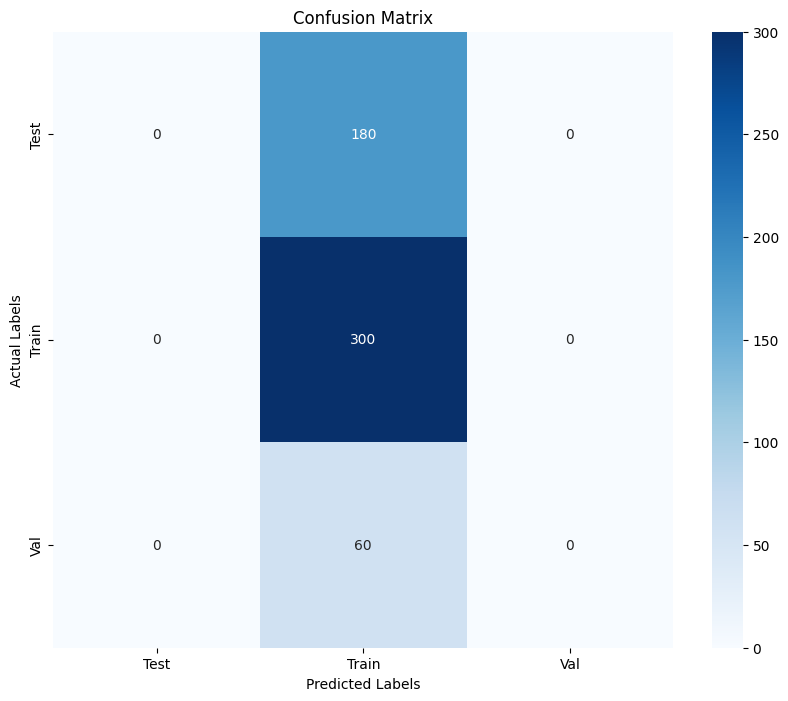

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the ground truth labels and predictions
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


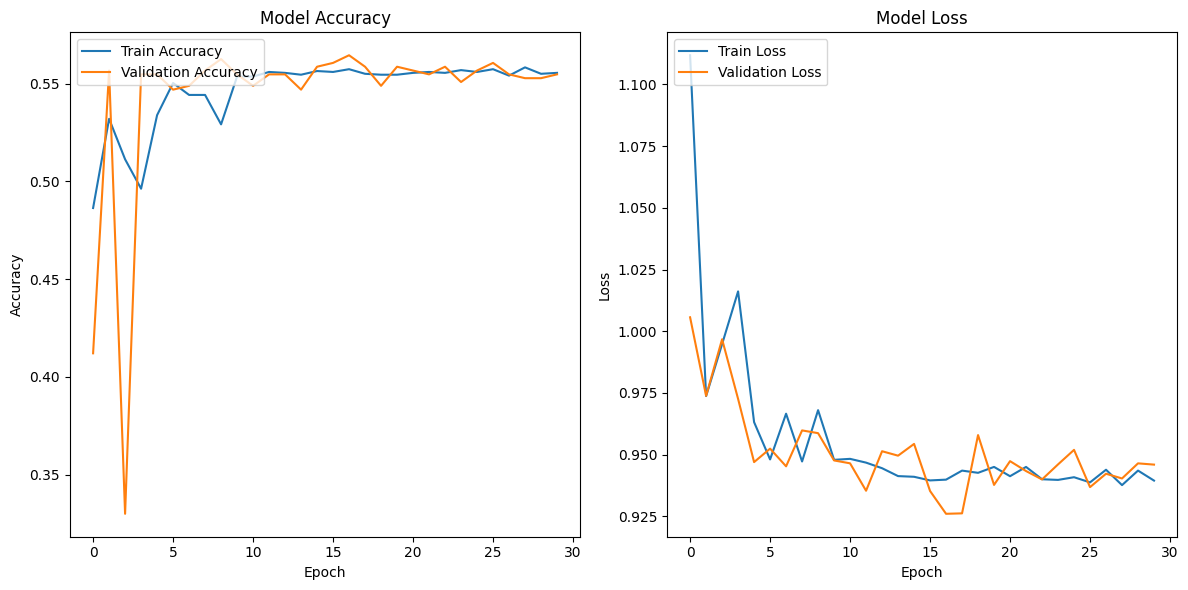

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()

# Save the image
plt.savefig('training_validation_accuracy_loss.png')
plt.show()
